In [1]:
#Load Libraries
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn.init
from torch.utils.data import Dataset
from torch.autograd import Variable
from PIL import Image
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchsummary
#import helper
import numpy as np
from tqdm import tqdm
from PIL import Image
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import torchvision
from sklearn.svm import OneClassSVM


# GPU 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 랜덤 시드 고정   
torch.manual_seed(123)

# GPU 사용 가능일 경우 랜덤 시드 고정
if device == 'cuda':
    torch.cuda.manual_seed_all(123)


In [2]:
#alexnet 전처리
preprocess = transforms.Compose([
    transforms.Resize(227),
    transforms.ToTensor(),
    transforms.CenterCrop(227),
    transforms.Grayscale(3),
])

In [151]:
data_labels = {
    0 : "Ban",
    1 : "Bicycle",
    2 : "Car",
    3 : "Circle",
    4 : "Down",
    5 : "Square",
    6 : "Triangle",
    7 : "Turn",
    8 : "Up"
    }


In [58]:
#데이터 불러오기
dataset = torchvision.datasets.ImageFolder(root="F:/backup/LAB/Datasets/RoadSign/Customdata/Class/", transform=preprocess)

#데이터 로더 생성
data_loader = torch.utils.data.DataLoader(dataset)

#라벨별로 데이터셋 분할
label_to_data = {}
for images, labels in data_loader:
    for image, label in zip(images, labels):
        #라벨에 해당하는 데이터 가져오기
        if label.item() not in label_to_data:
            label_to_data[label.item()] = []
        label_to_data[label.item()].append(image)

#분할된 데이터셋 확인
for label, data in label_to_data.items():
    print(f"Label : {label}")
    print(f'Number of samples : {len(data)}')

Label : 0
Number of samples : 44
Label : 1
Number of samples : 86
Label : 2
Number of samples : 34
Label : 3
Number of samples : 3720
Label : 4
Number of samples : 27
Label : 5
Number of samples : 3765
Label : 6
Number of samples : 3720
Label : 7
Number of samples : 22
Label : 8
Number of samples : 26


In [66]:

for idx in range(9):
    for i in range(len(label_to_data[idx])):
        label_to_data[idx][i] = label_to_data[idx][i].unsqueeze(0)

In [18]:
print(len(label_to_data[0]))

44


In [59]:
class AlexNet(nn.Module):
    
    def __init__(self):
        super(AlexNet, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels = 3,out_channels=96,kernel_size=11,stride=4,padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(96,256,5,1,2),
            nn.ReLU(),
            nn.MaxPool2d(3,2)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(256,384,3,1,1),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(384,384,3,1,1),
            nn.ReLU()
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(384,256,3,1,1),
            nn.ReLU(),
            nn.MaxPool2d(3,2)
        )
        
        self.fc1 = nn.Sequential(
            nn.Linear(256*6*6,4096)
        )
        
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = out.view(out.size(0), -1)
        
        out = self.fc1(out)
        return out

In [60]:
#Set hyper-parameter
learning_rate = 0.001
#training_epochs = 50
training_epochs = 5

In [73]:
#모델 정의

Model = [AlexNet().to(device)] * 9
SVM_Model = [OneClassSVM(gamma='auto', kernel='rbf')] * 9

In [74]:
#0-9모델 학습
Features = [[],[],[],[],[],[],[],[],[]]
for Number_Model in range(9):
    #변수 설정
    Y = torch.tensor(0).unsqueeze(0)
    total_batch = len(label_to_data[Number_Model])
    criterion = F.nll_loss
    optimizer = torch.optim.Adam(Model[Number_Model].parameters())



    #학습 시작
    print("{}번 모델 학습 시작".format(Number_Model))

    for epoch in range(training_epochs):
        avg_cost = 0
        for X in tqdm(label_to_data[Number_Model]):
            X = X.to(device)
            Y = Y.to(device)

            hypothesis = Model[Number_Model](X)
            optimizer.zero_grad()

            if epoch == training_epochs-1:
                for hypo in range(len(hypothesis)):
                    x = []
                    for i in hypothesis[hypo]:
                        x.append(i.item())
                    Features[Number_Model].append(x)

            cost = criterion(hypothesis, Y)

            cost.backward
            optimizer.step()
            avg_cost = cost / total_batch

        print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))



0번 모델 학습 시작


100%|██████████| 44/44 [00:02<00:00, 18.74it/s]


[Epoch:    1] cost = 7.18539195e-06
1번 모델 학습 시작


100%|██████████| 86/86 [00:04<00:00, 20.86it/s]


[Epoch:    1] cost = 1.59299398e-05
2번 모델 학습 시작


100%|██████████| 34/34 [00:01<00:00, 21.88it/s]


[Epoch:    1] cost = -3.53039613e-05
3번 모델 학습 시작


100%|██████████| 3720/3720 [02:48<00:00, 22.12it/s]


[Epoch:    1] cost = -2.13698158e-07
4번 모델 학습 시작


100%|██████████| 27/27 [00:01<00:00, 22.44it/s]


[Epoch:    1] cost = -0.000147193598
5번 모델 학습 시작


100%|██████████| 3765/3765 [02:58<00:00, 21.07it/s]


[Epoch:    1] cost = -2.30176866e-07
6번 모델 학습 시작


100%|██████████| 3720/3720 [03:09<00:00, 19.65it/s]


[Epoch:    1] cost = -2.53528356e-07
7번 모델 학습 시작


100%|██████████| 22/22 [00:01<00:00, 20.40it/s]


[Epoch:    1] cost = -0.000280790322
8번 모델 학습 시작


100%|██████████| 26/26 [00:01<00:00, 14.72it/s]

[Epoch:    1] cost = -0.000111316956


In [75]:
#SVM 모델 학습
for Number_Model in tqdm(range(9)):
    SVM_Model[Number_Model].fit(Features[Number_Model])

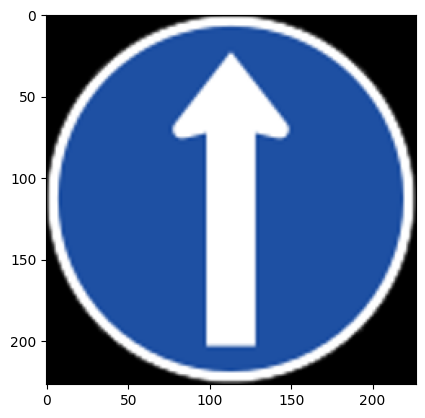

In [119]:
image = "F:/backup/LAB/Datasets/RoadSign/CustomData/origin/Sign (1).png"

img = Image.open(image).convert('RGB').resize((227,227))

#이미지 출력
plt.imshow(img)

#이미지 -> numpy -> tensor
img = np.array(img)
img = img.astype(np.float32)
img = torch.from_numpy(img).permute(2, 0, 1)


In [154]:
# 이미지 테스트 
Test_result = []
with torch.no_grad():
    for Number_Model in range(9):
        X = img.unsqueeze(0).to(device)
        predictions = Model[Number_Model](X)
        
        print(predictions[:100])
        #SVM
        Test_result.append(SVM_Model[Number_Model].predict(predictions))

tensor([[ 0.4200,  1.8408,  2.6131,  ...,  1.2281, -2.5689,  0.0466]])
tensor([[ 0.4200,  1.8408,  2.6131,  ...,  1.2281, -2.5689,  0.0466]])
tensor([[ 0.4200,  1.8408,  2.6131,  ...,  1.2281, -2.5689,  0.0466]])
tensor([[ 0.4200,  1.8408,  2.6131,  ...,  1.2281, -2.5689,  0.0466]])
tensor([[ 0.4200,  1.8408,  2.6131,  ...,  1.2281, -2.5689,  0.0466]])
tensor([[ 0.4200,  1.8408,  2.6131,  ...,  1.2281, -2.5689,  0.0466]])
tensor([[ 0.4200,  1.8408,  2.6131,  ...,  1.2281, -2.5689,  0.0466]])
tensor([[ 0.4200,  1.8408,  2.6131,  ...,  1.2281, -2.5689,  0.0466]])
tensor([[ 0.4200,  1.8408,  2.6131,  ...,  1.2281, -2.5689,  0.0466]])


In [153]:
for i, j  in enumerate(Test_result):
    if j == 1:
        print(data_labels[i])